In [ ]:
# GCN_LSTM
# HDD/Working/Naver_Traffic/IES/Model/GCN_LSTM_Ver/2_3_modi.ipynb

In [1]:
import cvxpy as cp # python 3.7 로 해야.... 하루종일 걸려서 발견...
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import pickle 

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


In [2]:
from labelling import XYGeneration

In [3]:
df_input = pd.read_csv("./data/Toy_data.csv")
df_target = pd.read_csv("./data/Toy_data_target.csv")

####### input df preprocessing
df_input.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)
# Date control 
df_input['Date'] = df_input.Date.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d'))
df_input = df_input.set_index('Date')

######## target df preprocessing 

# Date control 
df_target['Date'] = df_target.Date.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d') )
df_target = df_target.set_index('Date')

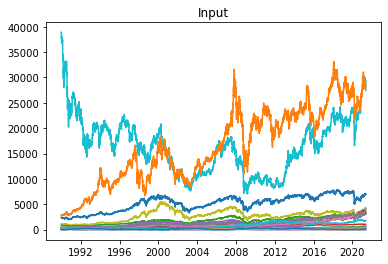

In [4]:
plt.title("Input")
plt.plot(df_input)
plt.show()

In [5]:
df_input.shape

(8184, 21)

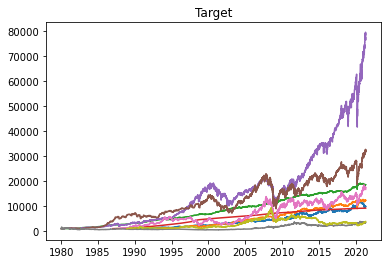

In [6]:
plt.title("Target")
plt.plot(df_target)
plt.show()

# NA handling

In [7]:
# NA handling

# df_input = df_input.dropna(axis = 0)
df_input = df_input.fillna(0)

df_target = df_target.dropna(axis = 0)


# Scaling

In [8]:
class StandardScaler():
    """
    Standard the input
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def transform(self, data):
        return (data - self.mean) / self.std
        
      # normalizing 푼다.   
    def inverse_transform(self, data):
        return (data * self.std) + self.mean

In [9]:
mean = df_input.mean(axis = 0)
std = df_input.std(axis = 0)

In [10]:
scaler = StandardScaler(mean, std)

In [11]:
df_input = scaler.transform(df_input)

In [26]:
target_past_duration = 253
rf = 0.02

In [27]:
generation = XYGeneration(df_target, target_past_duration, rf)

In [28]:
X_input, X_index = generation.X_generation(df_input, 120)

In [29]:
Y_label, Y_fut_date, Y_tot_date = generation.Y_generation()

In [30]:
len(X_input)

328

In [31]:
len(Y_label)

3

In [25]:
len(X_input[1])

320

In [19]:
X_input[0].head()

AttributeError: 'list' object has no attribute 'head'

In [19]:
X_input[0].shape

(65, 21)

In [20]:
len(Y_target[0])

9

In [21]:
Y_target[0]

array([0.14797, 0.17496, 0.25   , 0.25   , 0.09723, 0.     , 0.     ,
       0.05698, 0.02286])

# Feature Addition

In [22]:

def dayofweek(dff):
    dow = np.array([float(x) for x in dff.index.dayofweek])
    dow_tiled = np.tile(dow, [1, num_nodes, 1]).transpose((2,1,0))
    
    return dow_tiled



In [23]:
# Adding feautre for all set 
X = []
for dff in X_input:
    num_seq, num_nodes = dff.shape
    data = np.expand_dims(dff.values, axis= -1) # shape: ()
    feature_list = [data]
    
    # dayof week feature
    dow_tiled = dayofweek(dff)
    feature_list.append(dow_tiled)
    
    data = np.concatenate(feature_list, axis = -1)
    
    X.append(data)
    

In [24]:
len(X)

322

# DataLoader

In [25]:
from torch.utils.data import DataLoader

In [26]:
num_samples = len(X)
num_train = round(len(X)*0.7)
num_test = num_samples - num_train

In [27]:
x_train, y_train = X[:num_train], Y_target[:num_train]
x_test , y_test = X[num_train:], Y_target[num_train:]

In [28]:
np.array(x_train).shape

(225, 65, 21, 2)

In [61]:
x_test[0].shape

(65, 21, 2)

In [31]:
train_iter = ([(torch.from_numpy(x).float(),torch.from_numpy(y).float()) for x,y in zip(x_train, y_train)])
test_iter = ([(torch.from_numpy(x).float(),torch.from_numpy(y).float()) for x,y in zip(x_test, y_test)])

In [32]:
# np.expand_dims(y_train[0], axis = 0)

In [33]:

train_dataloader = DataLoader(train_iter, batch_size=12, shuffle=True, drop_last = True)
test_dataloader = DataLoader(test_iter, batch_size=12, shuffle=True, drop_last = True)

In [34]:
len(train_dataloader)

18

# Model 

In [38]:
import torch
import torch.nn.functional as F
import torch.nn as nn 

In [48]:
device = 'cuda:1'
learning_rate = 0.01

model = testmodel(device, num_nodes)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)

In [50]:
train_loss = []
for data in train_dataloader:
    model.zero_grad()
    
    X, Y = data
    X = X.transpose(3,1)
#     print (X.size())
    print (Y.size())
    out = model(X)
    print (out.size())
    out = out.squeeze()
    print(out.size())
    

    
    loss = criterion(out,Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_loss.append(loss.item())

torch.Size([12, 9])
torch.Size([12, 1, 1, 9])
torch.Size([12, 9])
torch.Size([12, 9])
torch.Size([12, 1, 1, 9])
torch.Size([12, 9])
torch.Size([12, 9])
torch.Size([12, 1, 1, 9])
torch.Size([12, 9])
torch.Size([12, 9])
torch.Size([12, 1, 1, 9])
torch.Size([12, 9])
torch.Size([12, 9])
torch.Size([12, 1, 1, 9])
torch.Size([12, 9])
torch.Size([12, 9])
torch.Size([12, 1, 1, 9])
torch.Size([12, 9])
torch.Size([12, 9])
torch.Size([12, 1, 1, 9])
torch.Size([12, 9])
torch.Size([12, 9])
torch.Size([12, 1, 1, 9])
torch.Size([12, 9])
torch.Size([12, 9])
torch.Size([12, 1, 1, 9])
torch.Size([12, 9])
torch.Size([12, 9])
torch.Size([12, 1, 1, 9])
torch.Size([12, 9])
torch.Size([12, 9])
torch.Size([12, 1, 1, 9])
torch.Size([12, 9])
torch.Size([12, 9])
torch.Size([12, 1, 1, 9])
torch.Size([12, 9])
torch.Size([12, 9])
torch.Size([12, 1, 1, 9])
torch.Size([12, 9])
torch.Size([12, 9])
torch.Size([12, 1, 1, 9])
torch.Size([12, 9])
torch.Size([12, 9])
torch.Size([12, 1, 1, 9])
torch.Size([12, 9])
torch.Size

In [5]:
import numpy as np 
a = 0.2
np.exp(a)

1.2214027581601699

In [46]:
## LSTM 확인 


data = next(iter(train_dataloader))









In [233]:
input, label  = (data)

In [234]:
input.size()

torch.Size([12, 65, 21, 2])

In [237]:
input[:, -1, :, :].size()

torch.Size([12, 21, 2])

In [55]:
[x.detach().numpy() for x in train_loss]

[array(0.01693066, dtype=float32),
 array(0.0152853, dtype=float32),
 array(0.01315648, dtype=float32),
 array(0.01089995, dtype=float32),
 array(0.0094362, dtype=float32),
 array(0.00711572, dtype=float32),
 array(0.00631291, dtype=float32),
 array(0.00589939, dtype=float32),
 array(0.00555849, dtype=float32),
 array(0.00525192, dtype=float32),
 array(0.00496996, dtype=float32),
 array(0.00470828, dtype=float32),
 array(0.00446427, dtype=float32),
 array(0.0042361, dtype=float32),
 array(0.00402234, dtype=float32),
 array(0.00382184, dtype=float32),
 array(0.00363361, dtype=float32),
 array(0.00345677, dtype=float32)]

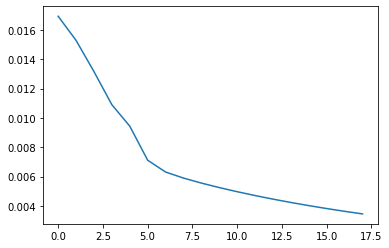

In [56]:
plt.plot([x.detach().numpy() for x in train_loss])

In [47]:
class testmodel(nn.Module):
    def __init__(self, device, num_nodes, layers = 13):
        super(testmodel, self).__init__()
        self.layers = layers
        self.start_conv = nn.Conv2d(in_channels=2, out_channels = 32,kernel_size = (1,1),
                                    dilation = 1, bias = True)
        self.out_conv = nn.Conv2d(in_channels= 32, out_channels = 9, kernel_size = (1,1), 
                                  dilation = 1, bias = True)
        self.end_conv = nn.Conv2d(in_channels = num_nodes, out_channels = 1, kernel_size = (1,1))
#         self.fc1 = nn.Linear()
        self.filter_conv = nn.ModuleList()

        for i in range(1,self.layers+1):
            
            self.filter_conv.append(nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (1,2),
                                             dilation = 5))
            
        
    def forward(self, input):
        in_len = input.size()
        
        x = nn.functional.pad(input,(1,0,0,0))
        
        x = self.start_conv(x)
        
        for i in range(self.layers):
#             print (i)
#             print (self.filter_conv[i])
            filter = self.filter_conv[i](x)
            
            filter = torch.tanh(filter)
#             print ('size: ',filter.size())
            x = filter
            
        x = self.out_conv(x)
        
        x = x.transpose(3,1)
        
        x = x.transpose(2,1)
        
        x = self.end_conv(x)
        return x